In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.cosmology import Planck18 as cosmo
from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial

sys.path.append(os.environ['DM21CM_DIR'])
from preprocessing.accretion import PBHAccretionModel, Mdot_PR, Mdot_BHL
from preprocessing.halo import *
# from dm21cm.preprocessing.hmf import *
from dm21cm.utils import load_h5_dict

sys.path.append(os.environ['DH_DIR'])
from darkhistory import physics as dh_phys

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


In [2]:
from astropy.cosmology import Planck18
import py21cmfast as p21c

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:43: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Default cache dir: /n/netscratch/iaifi_lab/Lab/yitians/dm21cm/21cmFAST-cache


In [6]:
user_params = p21c.UserParams(
    HII_DIM = 64,
    BOX_LEN = 256, # [conformal Mpc]
    N_THREADS = 32,
)
user_params.USE_RELATIVE_VELOCITIES

False

In [13]:
p21c_astro_params = p21c.AstroParams(
    F_STAR10 = -1.25,
    F_STAR7_MINI = -2.5,
    ALPHA_STAR = 0.5,
    ALPHA_STAR_MINI = 0.0,
    t_STAR = 0.5,
    F_ESC10 = -1.35,
    F_ESC7_MINI = -1.35,
    ALPHA_ESC = -0.3,
    L_X = 40.5,
    L_X_MINI = 40.5,
    NU_X_THRESH = 500,
    A_LW = 2.0,
)

In [15]:
dir(user_params)

['BOX_LEN',
 'DIM',
 'FAST_FCOLL_TABLES',
 'HII_DIM',
 'HII_tot_num_pixels',
 'HMF',
 'MINIMIZE_MEMORY',
 'NO_RNG',
 'N_THREADS',
 'PERTURB_ON_HIGH_RES',
 'POWER_SPECTRUM',
 'USE_2LPT',
 'USE_FFTW_WISDOM',
 'USE_INTERPOLATION_TABLES',
 'USE_RELATIVE_VELOCITIES',
 '_DIM',
 '_FAST_FCOLL_TABLES',
 '_HMF',
 '_POWER_SPECTRUM',
 '_USE_INTERPOLATION_TABLES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cstruct',
 '_defaults_',
 '_ffi',
 '_get_name',
 '_hmf_models',
 '_name',
 '_new',
 '_power_models',
 'clone',
 'convert',
 'defining_dict',
 'fieldnames',
 'fields',
 'get_fieldnames',
 'get_fields',
 'get_pointer_fields',
 'hmf_model',
 'poi

In [ ]:
cosmo_params = p21c.CosmoParams(
    OMm = Planck18.Om0,
    OMb = Planck18.Ob0,
    POWER_INDEX = Planck18.meta['n'],
    SIGMA_8 = Planck18.meta['sigma8'],
    hlittle = Planck18.h,
)


['OMb',
 'OMl',
 'OMm',
 'POWER_INDEX',
 'SIGMA_8',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cstruct',
 '_defaults_',
 '_ffi',
 '_get_name',
 '_name',
 '_new',
 'clone',
 'convert',
 'cosmo',
 'defining_dict',
 'fieldnames',
 'fields',
 'get_fieldnames',
 'get_fields',
 'get_pointer_fields',
 'hlittle',
 'pointer_fields',
 'primitive_fields',
 'pystruct',
 'refresh_cstruct',
 'self',
 'update']

In [7]:
p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 64,
        BOX_LEN = 256, # [conformal Mpc]
        N_THREADS = 32,
        USE_RELATIVE_VELOCITIES = True,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 12345,
    write = True,
)

2025-06-07 14:58:25,658 | WARNING | inputs.py::POWER_SPECTRUM() | Automatically setting POWER_SPECTRUM to 5 (CLASS) as you are using relative velocities
2025-06-07 14:58:25,659 | WARNING | inputs.py::POWER_SPECTRUM() | Automatically setting POWER_SPECTRUM to 5 (CLASS) as you are using relative velocities


2025-06-07 14:58:29,218 | WARNING | inputs.py::POWER_SPECTRUM() | Automatically setting POWER_SPECTRUM to 5 (CLASS) as you are using relative velocities


(array([ 5855., 34244., 66658., 70532., 48968., 24489.,  8461.,  2156.,
          593.,   188.]),
 array([ 0.12984851,  6.74490786, 13.35996723, 19.97502708, 26.59008598,
        33.20514679, 39.82020569, 46.43526459, 53.05032349, 59.66538239,
        66.28044128]),
 <BarContainer object of 10 artists>)

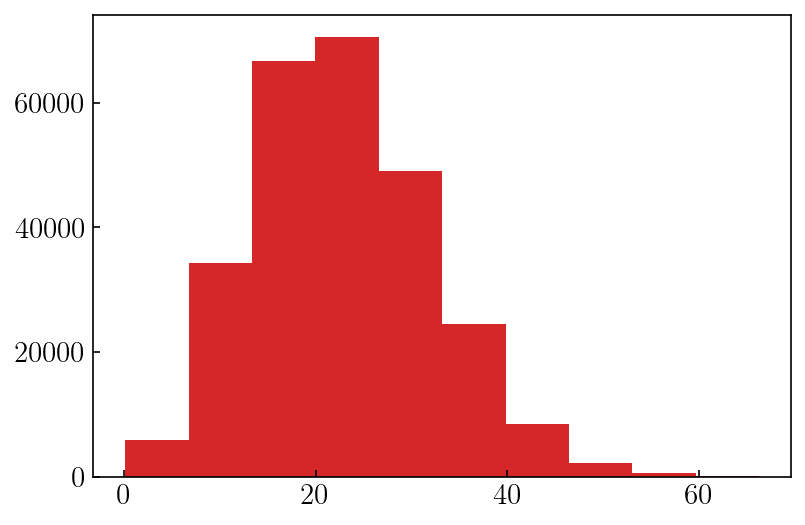

In [11]:
plt.hist((p21c_initial_conditions.lowres_vcb).flatten())

In [9]:
p21c_initial_conditions.lowres_vcb.shape

(64, 64, 64)